In [1]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

### Champion Notes:
##### all champs:
- 30/34 champions were top 5 in team_rating_custom
- 31/34 champions were break_even_over500_PD
- 31/34 champions were top 8 in MoV
- 30/34 champions were 500_rec_7pt_or_less

- last 4 champions were top 4 in team_rating_custom
- last 4 champions were top 6 in sum_mvp_shares_L4S
- last 4 champions were top 6 passing_offense_Y/G
- last 13 champions had 2 or greater passing_offense_GWD
- last 6 champions were top 4 in pso

In [4]:
df_raw = pd.read_csv("NFL Champion RawData.csv")
df = pd.read_csv("NFL Champion LR Data.csv")
print(list(df))

['season', 'Team', 'team_id', 'conference', 'divisions', 'round', 'champion_share', 'champion', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP'

In [13]:
data_columns = ['champion_share','W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','seed','team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C', 'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP', 'pso', 'over500_rec', 'over600_rec', 'rec_7pt_or_less', 'sum_games_7pts_or_less', 'over500_PD', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_opoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 'sum_champion_shares', 'sum_champions', 'sum_playoff_games', 'sum_mvp_shares_L4S', 'sum_dpoy_shares_L4S', 'sum_player_L1S_cs', 'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference_record', 'divisions_record', 'sum_coach_playoff_games', 'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_FG%', 'Scoring_Lng', 'Scoring_XP%', 'break_even_over500_PD', 'sum_QB_playoff_games', 'QB_Age', 'sum_QB_mvp_shares', 'sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs', 'QB_2_or_more_GWD', '500_rec_7pt_or_less', '625_rec', 'SRS_greater_than_1.5_pts', 'team_rating_custom']
                
df= df.dropna(subset=data_columns)

data = df[data_columns].copy()

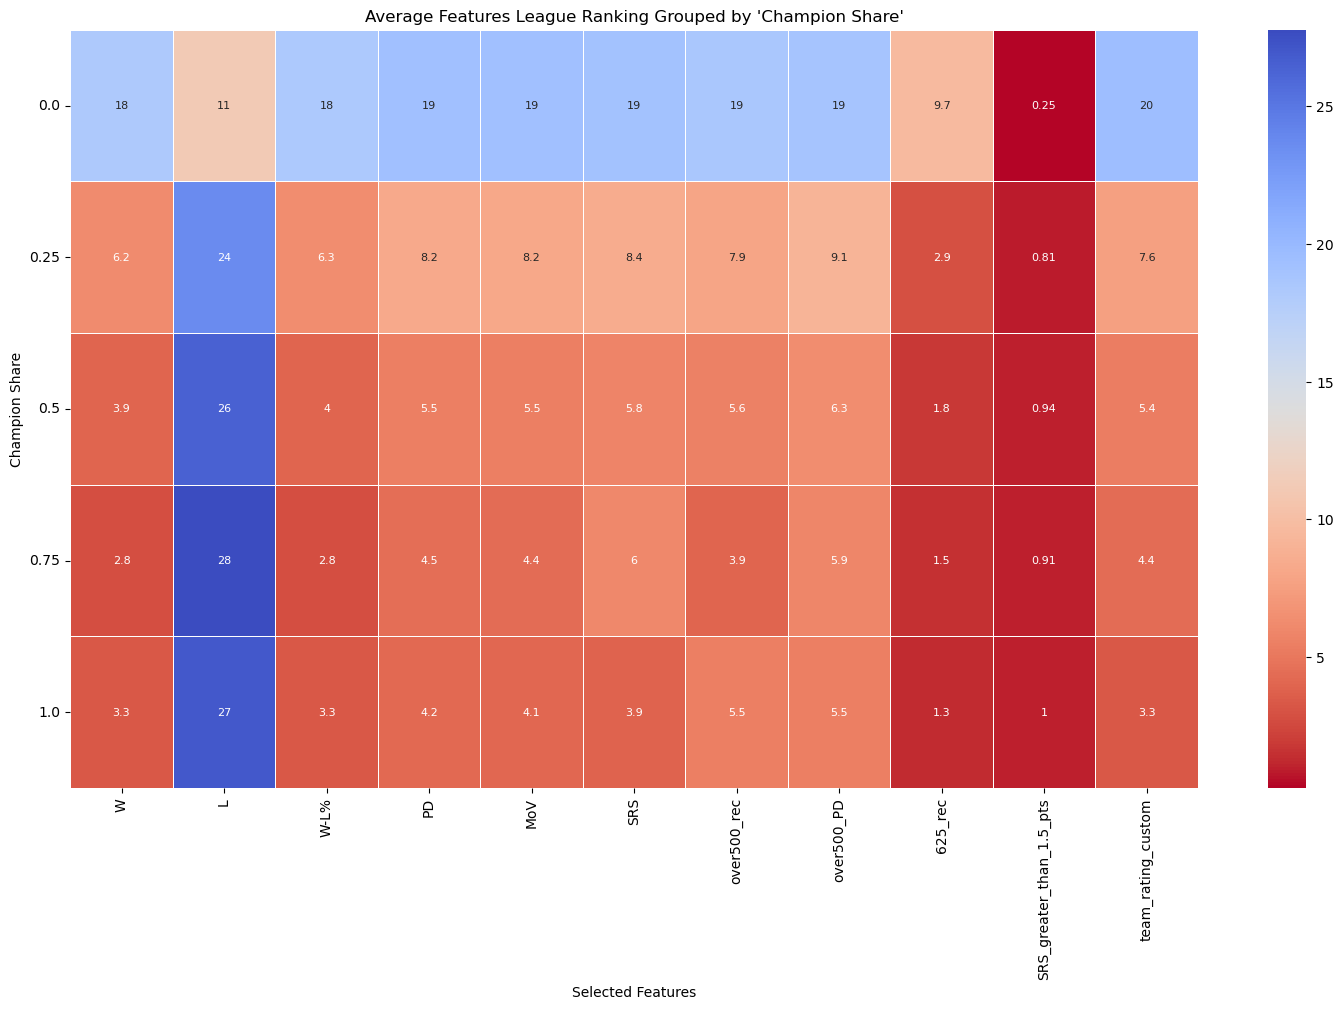

In [14]:
corr = data.corr().abs()
selected_features = corr.loc[corr['champion_share'] > 0.5].index

corr_df = data[selected_features].groupby('champion_share').mean()

plt.rcParams['figure.figsize'] = (15, 10)
plt.title("Average Features League Ranking Grouped by 'Champion Share'")
heatmap = sns.heatmap(data=corr_df, cmap='coolwarm_r', annot=True, linewidth=.5, annot_kws={"size": 8})

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel("Selected Features")
plt.ylabel("Champion Share")

plt.savefig("avg_fea_ht.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("avg_fea_ht.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("avg_fea_ht.png")

plt.show()

In [9]:
df = pd.read_csv("NFL Champion LR Data.csv")

champions_df = df[df['champion_share'] == 1]
unique_ranks = champions_df['team_rating_custom'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['team_rating_custom'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions {rank}: {percentage:.0f}%")

The percentage of champions Rank 1.0: 29%
The percentage of champions Rank 4.0: 21%
The percentage of champions Rank 3.0: 18%
The percentage of champions Rank 2.0: 18%
The percentage of champions Rank 5.0: 3%
The percentage of champions Rank 13.0: 3%
The percentage of champions Rank 9.0: 3%
The percentage of champions Rank 7.0: 3%
The percentage of champions Rank 10.0: 3%


In [15]:
29+21+18+18+3

89

In [18]:
df = pd.read_csv("NFL Champion LR Data.csv")

champions_df = df[df['champion_share'] == 1]
unique_ranks = champions_df['MoV'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['MoV'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions {rank}: {percentage:.0f}%")

The percentage of champions Rank 1.0: 29%
The percentage of champions Rank 2.0: 26%
The percentage of champions Rank 4.0: 12%
The percentage of champions Rank 5.0: 9%
The percentage of champions Rank 6.0: 6%
The percentage of champions Rank 10.0: 3%
The percentage of champions Rank 11.0: 3%
The percentage of champions Rank 19.0: 3%
The percentage of champions Rank 13.0: 3%
The percentage of champions Rank 9.0: 3%
The percentage of champions Rank 7.0: 3%


In [20]:
29+26+12+9

76

In [19]:
df = pd.read_csv("NFL Champion LR Data.csv")

champions_df = df[df['champion_share'] == 1]
unique_ranks = champions_df['SRS'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['SRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions {rank}: {percentage:.0f}%")

The percentage of champions Rank 1.0: 32%
The percentage of champions Rank 2.0: 24%
The percentage of champions Rank 6.0: 9%
The percentage of champions Rank 7.0: 6%
The percentage of champions Rank 4.0: 6%
The percentage of champions Rank 8.0: 6%
The percentage of champions Rank 12.0: 6%
The percentage of champions Rank 5.0: 6%
The percentage of champions Rank 11.0: 3%
The percentage of champions Rank 3.0: 3%


In [21]:
32+24+3+6+6

71

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


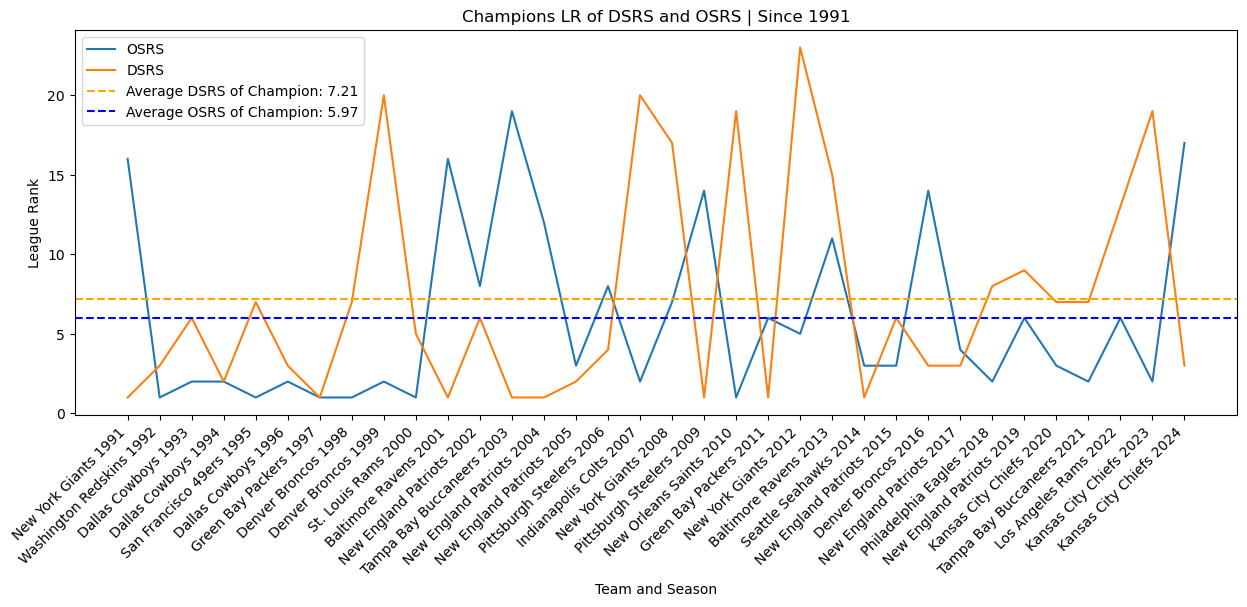

In [24]:
champion_sea = df.loc[df['champion_share'] == 1].copy() 

champion_sea.sort_values(by='season', inplace=True)

champion_sea['season'] = champion_sea['season'].astype(str)

plt.figure(figsize=(15, 5))
plt.title("Champions LR of DSRS and OSRS | Since 1991")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['season'], y=champion_sea['OSRS'], label="OSRS")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['season'], y=champion_sea['DSRS'], label="DSRS")

average_dsrs = champion_sea['DSRS'].mean()
average_osrs = champion_sea['OSRS'].mean()

plt.axhline(y=average_dsrs, color='orange', linestyle='--', label=f'Average DSRS of Champion: {average_dsrs:.2f}')
plt.axhline(y=average_osrs, color='blue', linestyle='--', label=f'Average OSRS of Champion: {average_osrs:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('League Rank')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.savefig("line_chart_OvD.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_OvD.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_OvD.png")

plt.show()

In [25]:
df = pd.read_csv("NFL Champion LR Data.csv")

champions_df = df[df['champion_share'] == 1]
unique_ranks = champions_df['team_defense_EXP'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['team_defense_EXP'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions {rank}: {percentage:.0f}%")

The percentage of champions Rank 1.0: 41%
The percentage of champions Rank 2.0: 15%
The percentage of champions Rank 20.0: 6%
The percentage of champions Rank 8.0: 6%
The percentage of champions Rank 6.0: 6%
The percentage of champions Rank 3.0: 6%
The percentage of champions Rank 4.0: 3%
The percentage of champions Rank 17.0: 3%
The percentage of champions Rank 7.0: 3%
The percentage of champions Rank 21.0: 3%
The percentage of champions Rank 16.0: 3%
The percentage of champions Rank 24.0: 3%
The percentage of champions Rank 9.0: 3%


In [27]:
df = pd.read_csv("NFL Champion LR Data.csv")

champions_df = df[df['champion_share'] == 1]
unique_ranks = champions_df['team_offense_EXP'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['team_offense_EXP'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions {rank}: {percentage:.0f}%")

The percentage of champions Rank 1.0: 41%
The percentage of champions Rank 11.0: 6%
The percentage of champions Rank 6.0: 6%
The percentage of champions Rank 3.0: 6%
The percentage of champions Rank 4.0: 6%
The percentage of champions Rank 2.0: 6%
The percentage of champions Rank 27.0: 3%
The percentage of champions Rank 5.0: 3%
The percentage of champions Rank 10.0: 3%
The percentage of champions Rank 8.0: 3%
The percentage of champions Rank 28.0: 3%
The percentage of champions Rank 19.0: 3%
The percentage of champions Rank 15.0: 3%
The percentage of champions Rank 21.0: 3%
The percentage of champions Rank 20.0: 3%
The percentage of champions Rank 24.0: 3%


In [6]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'sum coach rs games', 'sum coach playoff games', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD

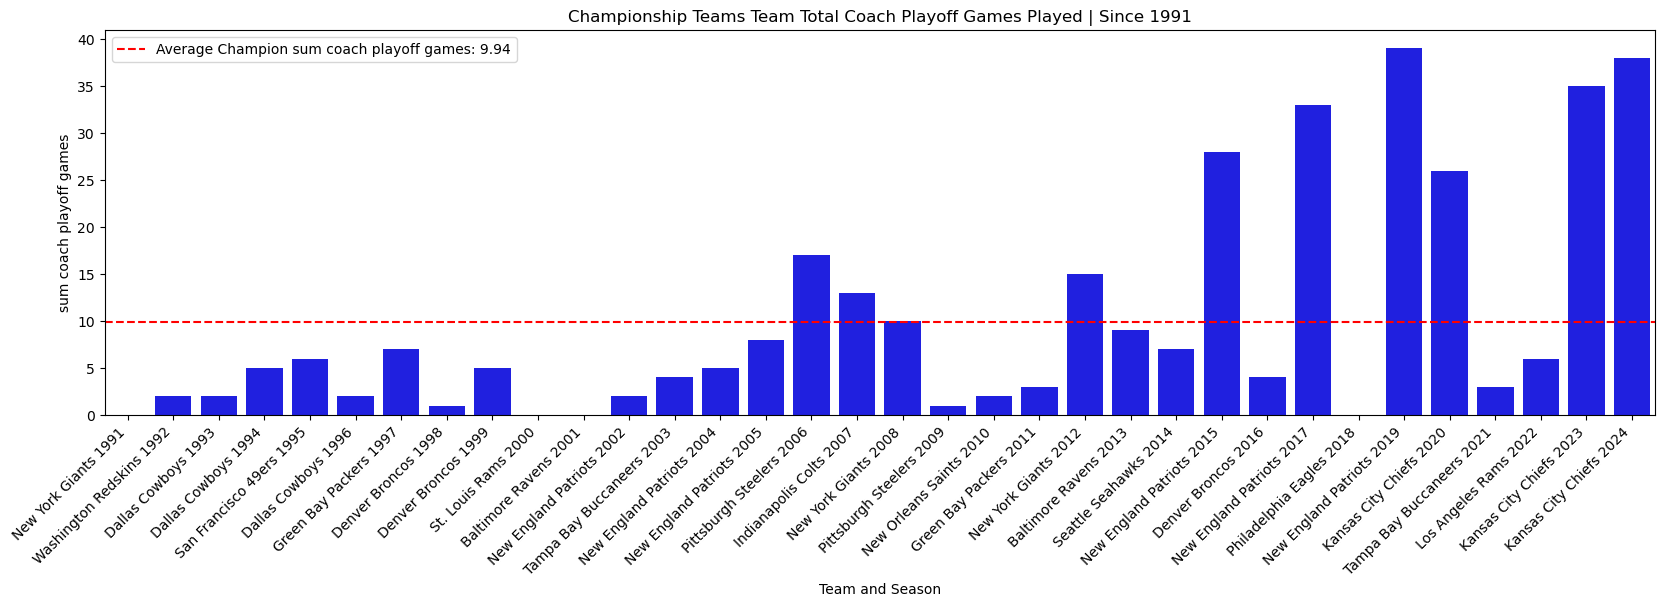

In [27]:
df = pd.read_csv("NFL Champion RawData.csv")

champion_sea = df.loc[df['champion_share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Coach Playoff Games Played | Since 1991")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum_coach_playoff_games'], color='blue')

average_mvp = champion_sea['sum_coach_playoff_games'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum coach playoff games: {average_mvp:.2f}')

plt.xlim(-0.5, len(champion_sea) - 0.5)

plt.xlabel('Team and Season')
plt.ylabel('sum coach playoff games')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("nfl_coa_playo_exp", bbox_inches='tight', pad_inches=0.1)
image = Image.open("nfl_coa_playo_exp.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("nfl_coa_playo_exp.png")

plt.show()

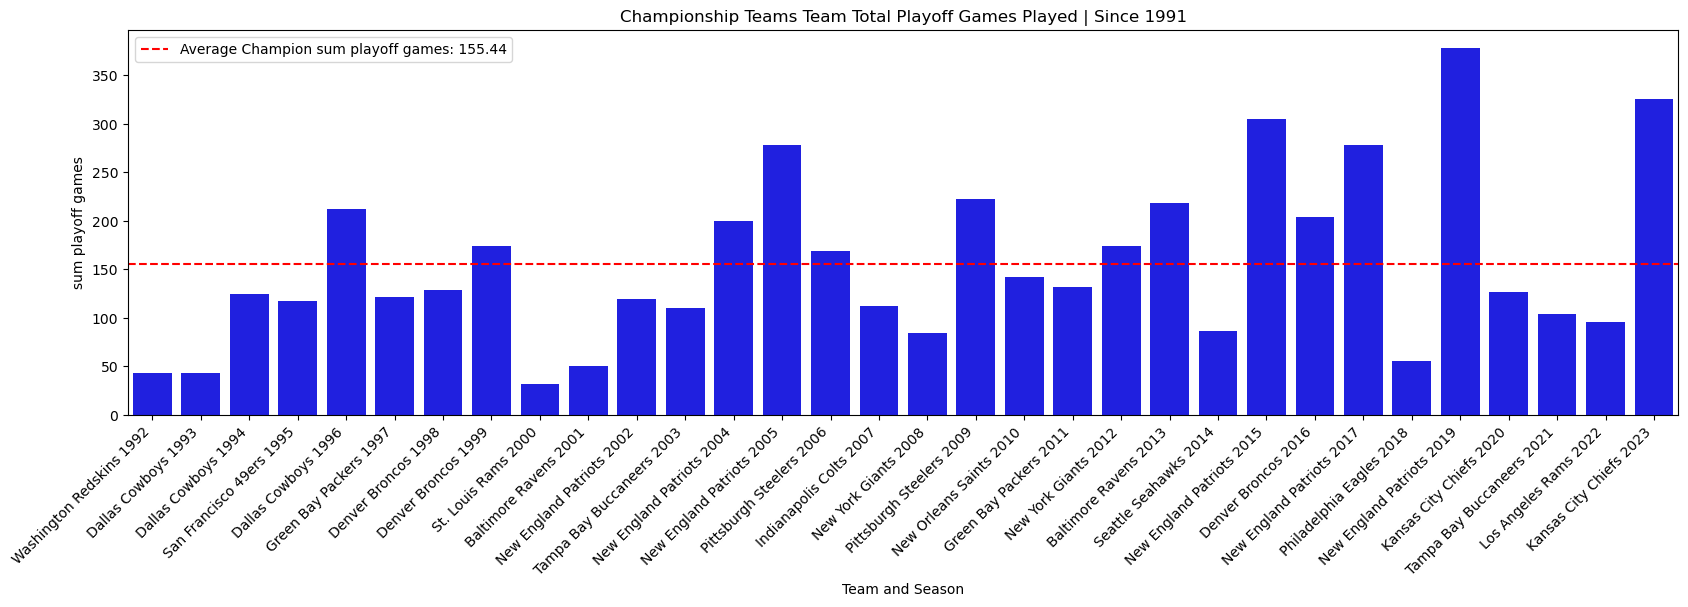

In [22]:
df = pd.read_excel("NFL Champion RawData.xlsx")
#df = pd.read_csv("NFL Champion LR Data.csv")
df.drop(df[df['Season'] < 1992].index, inplace = True)

champion_sea = df.loc[df['champion share'] == 1].copy()  

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

champion_sea['team_season'] = champion_sea['Team'] + ' ' + champion_sea['Season']

plt.figure(figsize=(20, 5))
plt.title("Championship Teams Team Total Playoff Games Played | Since 1991")

sns.barplot(x=champion_sea['team_season'], y=champion_sea['sum playoff games'], color='blue')

average_mvp = champion_sea['sum playoff games'].mean()

plt.axhline(y=average_mvp, color='r', linestyle='--', label=f'Average Champion sum playoff games: {average_mvp:.2f}')

plt.xlim(-0.5, len(champion_sea) - 0.5)

plt.xlabel('Team and Season')
plt.ylabel('sum playoff games')
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(True)

plt.savefig("nfl_tm_playo_exp", bbox_inches='tight', pad_inches=0.1)
image = Image.open("nfl_tm_playo_exp.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("nfl_tm_playo_exp.png")

plt.show()

In [32]:
df = pd.read_excel("NFL Champion RawData.xlsx")
#df = pd.read_csv("NFL Champion LR Data.csv")
df.drop(df[df['Season'] < 1992].index, inplace = True)
#print(list(df.columns))


champion = df.loc[df['champion share'] == 1]
champion_misc_stats = champion['sum playoff games'].describe()

print("Summary Statistics for Champions' 'sum playoff games':")
print(champion_misc_stats)

Summary Statistics for Champions' 'sum playoff games':
count     32.000000
mean     155.437500
std       87.268565
min       32.000000
25%      102.000000
50%      128.000000
75%      206.000000
max      378.000000
Name: sum playoff games, dtype: float64


C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


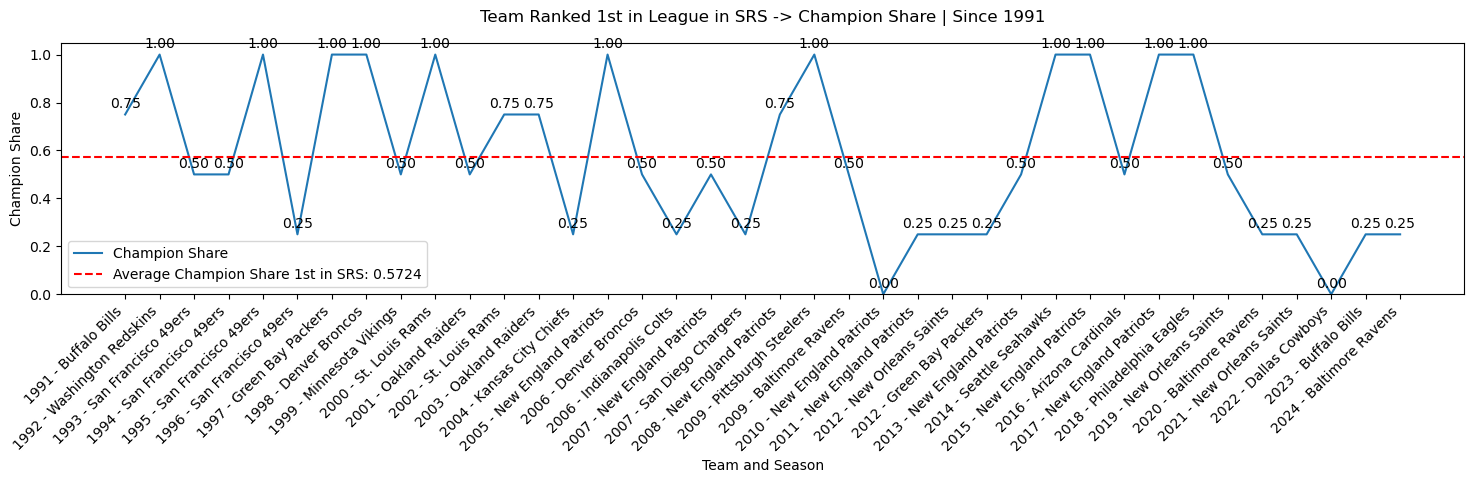

In [23]:
#df = pd.read_excel("NFL Champion RawData.xlsx")
df = pd.read_csv("NFL Champion LR Data.csv")


first_in_league_SRS = df.loc[df['SRS'] == 1].copy()
first_in_league_SRS .sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 1991")

plt.title("Team Ranked 1st in League in SRS -> Champion Share | Since 1991", y=1.05)

first_in_league_SRS.loc[:, 'Season'] = first_in_league_SRS['Season'].astype(str)

sns.lineplot(x=first_in_league_SRS['Season'] + " - " + first_in_league_SRS['Team'],
             y=first_in_league_SRS['champion share'],
             label="Champion Share", errorbar=None)

plt.xticks(rotation=45, ha="right")

for i, row in first_in_league_SRS.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

average_champion_share = first_in_league_SRS['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in SRS: {average_champion_share:.4f}')

plt.xlabel("Team and Season")
plt.ylabel("Champion Share")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_1st_SRS.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_1st_SRS.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_1st_SRS.png")

plt.show()

In [24]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['SRS'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['SRS'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions SRS rank {rank}: {percentage:.2f}%")

The percentage of champions SRS rank Rank 1.0: 33.33%
The percentage of champions SRS rank Rank 2.0: 24.24%
The percentage of champions SRS rank Rank 6.0: 9.09%
The percentage of champions SRS rank Rank 4.0: 6.06%
The percentage of champions SRS rank Rank 8.0: 6.06%
The percentage of champions SRS rank Rank 12.0: 6.06%
The percentage of champions SRS rank Rank 5.0: 6.06%
The percentage of champions SRS rank Rank 11.0: 3.03%
The percentage of champions SRS rank Rank 7.0: 3.03%
The percentage of champions SRS rank Rank 3.0: 3.03%


In [26]:
33.33+24.24

57.56999999999999

### Analysis of SRS
- On average teams ranked 1st in the league in SRS, get around 2.1 playoff wins (remember 1 seeds automatically get 1 playoff win (by))
- 75% of all NFL champions ranked top 6 in the league in SRS, specifically the top 2 spots are the most important.

In [18]:
29.17+16.67+4.17+8.33+4.17+12.5

75.01

C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


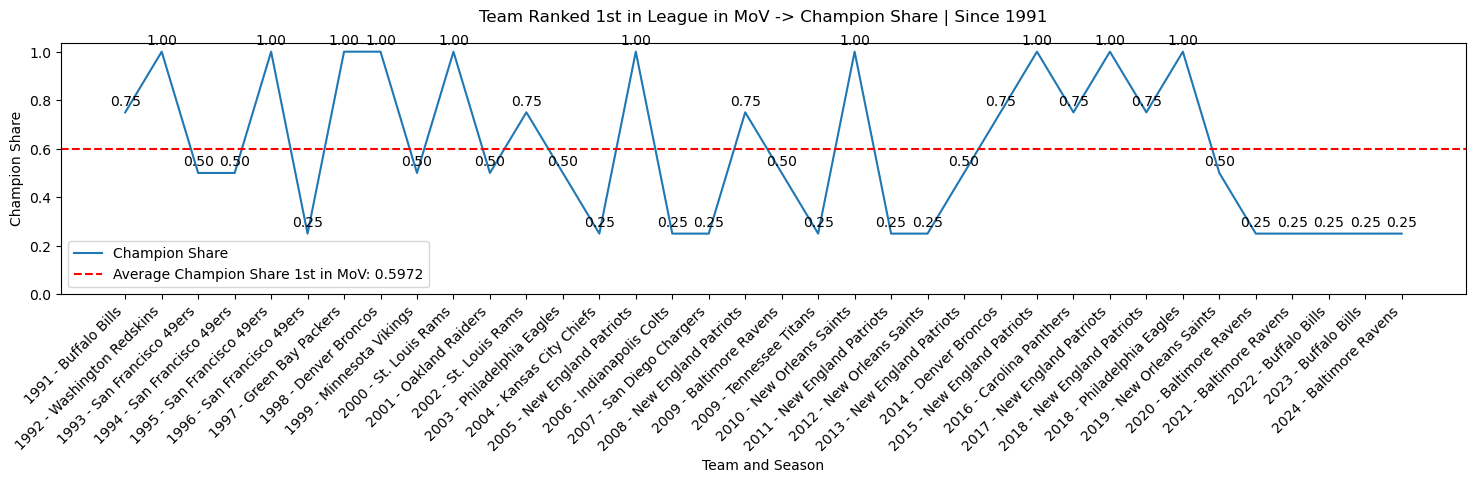

In [18]:
#df = pd.read_excel("NFL Champion RawData.xlsx")
df = pd.read_csv("NFL Champion LR Data.csv")


first_in_league_MoV = df.loc[df['MoV'] == 1].copy()

first_in_league_MoV.sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 5))
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 1991")
plt.title("Team Ranked 1st in League in MoV -> Champion Share | Since 1991", y=1.05)

first_in_league_MoV.loc[:, 'Season'] = first_in_league_MoV['Season'].astype(str)

sns.lineplot(x=first_in_league_MoV['Season'] + " - " + first_in_league_MoV['Team'],
             y=first_in_league_MoV['champion share'],
             label="Champion Share", errorbar=None)

plt.xticks(rotation=45, ha="right")

for i, row in first_in_league_MoV.iterrows():
    plt.annotate(f"{row['champion share']:.2f}", (row['Season'] + " - " + row['Team'], row['champion share']),
                 textcoords="offset points", xytext=(0, 5), ha='center')

average_champion_share = first_in_league_MoV['champion share'].mean()
plt.axhline(y=average_champion_share, color='r', linestyle='--', label=f'Average Champion Share 1st in MoV: {average_champion_share:.4f}')

plt.xlabel("Team and Season")
plt.ylabel("Champion Share")
plt.ylim(bottom=0)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'sum coach rs games', 'sum coach playoff games', 'FantPt_team_avg', 'FantPt_team_max', 'over600 rec', 'sum gs over600', 'over500 rec', 'over500 mov', '7 <= rec', 'sum wins 20 >=', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp',

C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


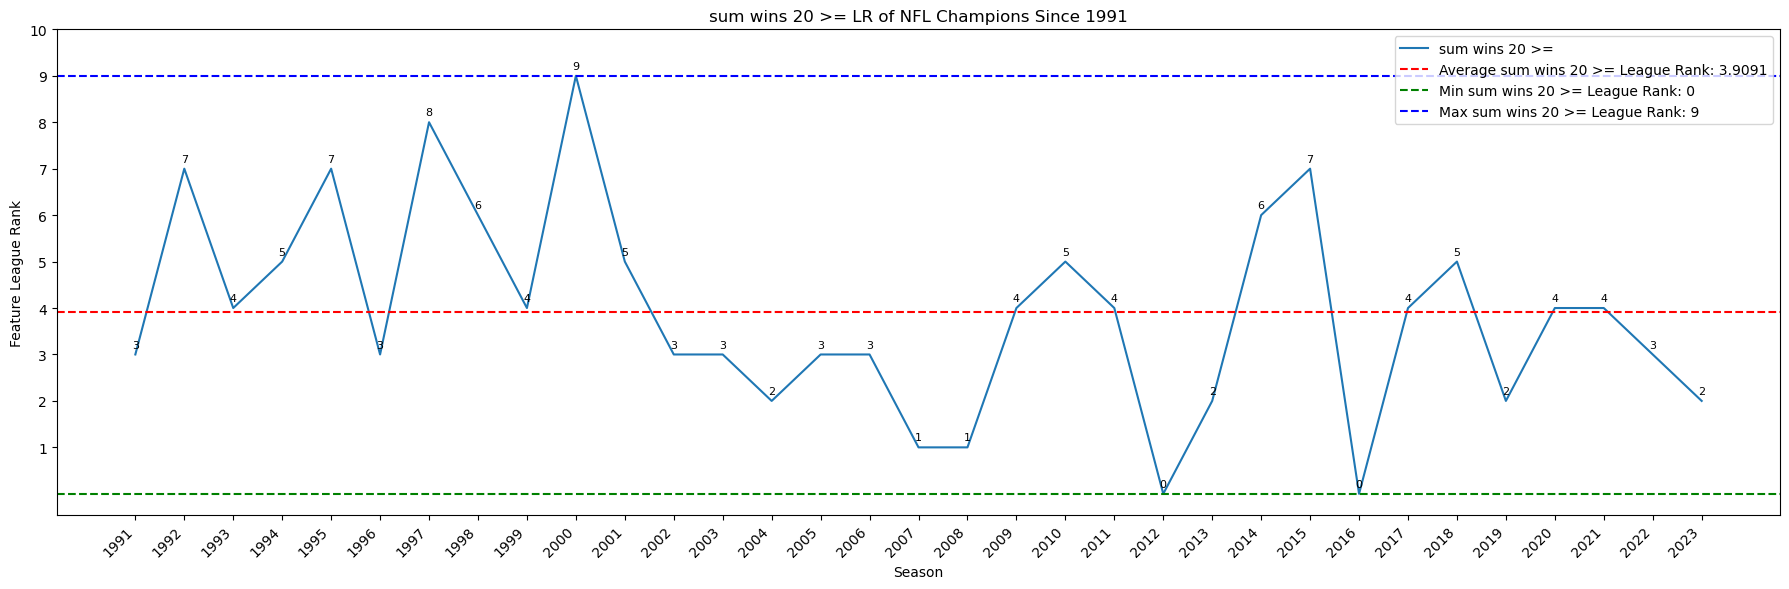

In [17]:
df = pd.read_excel("NFL Champion RawData.xlsx")
#df = pd.read_csv("NFL Champion LR Data.csv")
#df.drop(df[df['Season'] < 1992].index, inplace = True)

champion = df.loc[df['champion share'] == 1.00]

plt.figure(figsize=(18, 6))

sns.lineplot(x=champion['Season'], y=champion['sum wins 20 >='], label="sum wins 20 >=", err_style="band")

plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

plt.yticks(range(1, 11))

average_champion_wins_ranking = champion['sum wins 20 >='].mean()
min_champion_wins_ranking = champion['sum wins 20 >='].min()
max_champion_wins_ranking = champion['sum wins 20 >='].max()

plt.axhline(y=average_champion_wins_ranking, color='r', linestyle='--', label=f'Average sum wins 20 >= League Rank: {average_champion_wins_ranking:.4f}')
plt.axhline(y=min_champion_wins_ranking, color='g', linestyle='--', label=f'Min sum wins 20 >= League Rank: {min_champion_wins_ranking}')
plt.axhline(y=max_champion_wins_ranking, color='b', linestyle='--', label=f'Max sum wins 20 >= League Rank: {max_champion_wins_ranking}')

for season, rank in zip(champion['Season'], champion['sum wins 20 >=']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("sum wins 20 >= LR of NFL Champions Since 1991")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()
plt.tight_layout()

#plt.savefig("line_chart_wins.png", bbox_inches='tight', pad_inches=0.1)
#image = Image.open("line_chart_wins.png")
#image_with_border = ImageOps.expand(image, border=2, fill='black')
#image_with_border.save("line_chart_wins.png")

plt.show()

In [1]:
.6071*4

2.4284

In [9]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['MoV'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['MoV'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions MoV rank {rank}: {percentage:.2f}%")

The percentage of champions MoV rank Rank 1.0: 30.30%
The percentage of champions MoV rank Rank 2.0: 27.27%
The percentage of champions MoV rank Rank 4.0: 12.12%
The percentage of champions MoV rank Rank 5.0: 9.09%
The percentage of champions MoV rank Rank 6.0: 3.03%
The percentage of champions MoV rank Rank 10.0: 3.03%
The percentage of champions MoV rank Rank 11.0: 3.03%
The percentage of champions MoV rank Rank 19.0: 3.03%
The percentage of champions MoV rank Rank 13.0: 3.03%
The percentage of champions MoV rank Rank 9.0: 3.03%
The percentage of champions MoV rank Rank 7.0: 3.03%


### Analysis of MoV
- On average teams ranked 1st in the league in MoV, get around 2.3 playoff wins (remember 1 seeds automatically get 1 playoff win (by))
- 75% of all NFL champions ranked top 6 in the league in MoV, specifically the top is the most important.

In [22]:
25+16.67+16.67+12.5+4.17

75.01

In [24]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


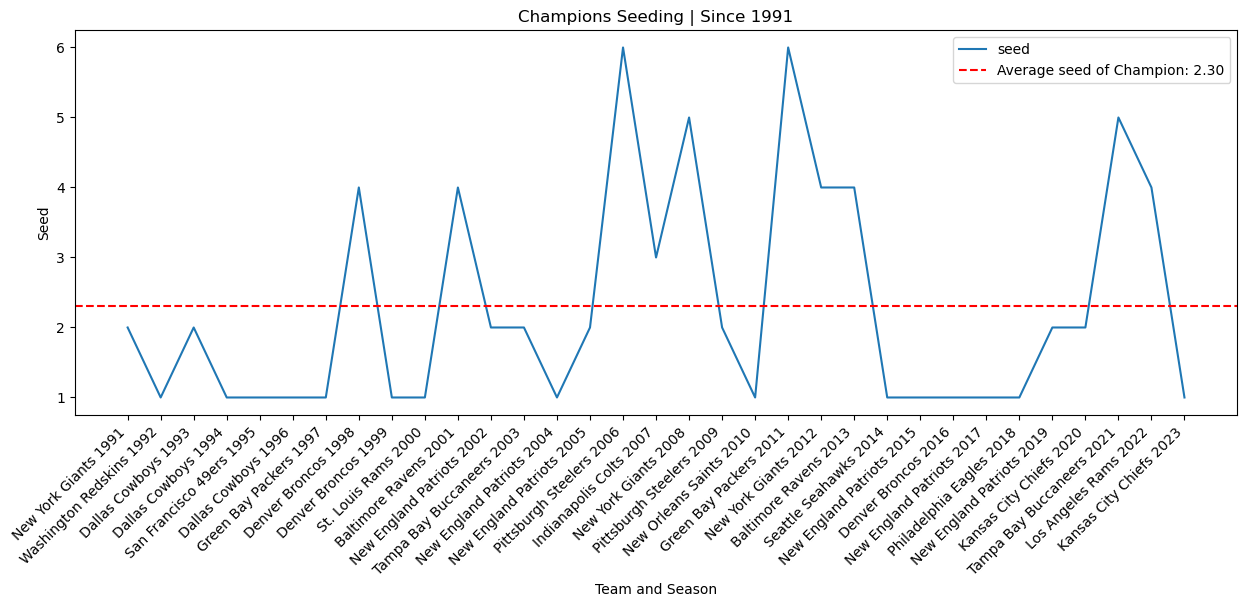

In [24]:
champion_sea = df.loc[df['champion share'] == 1].copy() 

champion_sea.sort_values(by='Season', inplace=True)

champion_sea['Season'] = champion_sea['Season'].astype(str)

plt.figure(figsize=(15, 5))
plt.title("Champions Seeding | Since 1991")
sns.lineplot(x=champion_sea['Team'] + ' ' + champion_sea['Season'], y=champion_sea['seed'], label="seed")

average_dsrs = champion_sea['seed'].mean()

plt.axhline(y=average_dsrs, color='r', linestyle='--', label=f'Average seed of Champion: {average_dsrs:.2f}')

plt.xlabel('Team and Season')
plt.ylabel('Seed')

plt.xticks(rotation=45, ha='right')
plt.legend()

plt.savefig("line_chart_seeding.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_seeding.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_seeding.png")

plt.show()

In [30]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['rk playoffs'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['rk playoffs'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions seed {rank}: {percentage:.2f}%")

The percentage of champions seed Rank 1: 37.50%
The percentage of champions seed Rank 2: 25.00%
The percentage of champions seed Rank 4: 16.67%
The percentage of champions seed Rank 5: 8.33%
The percentage of champions seed Rank 6: 8.33%
The percentage of champions seed Rank 3: 4.17%


Average Champion Share by Seed | Since 1991
seed
1    0.617647
2    0.514706
4    0.257353
3    0.202206
6    0.150735
5    0.128676
7    0.031250
0    0.000000
Name: champion_share, dtype: float64


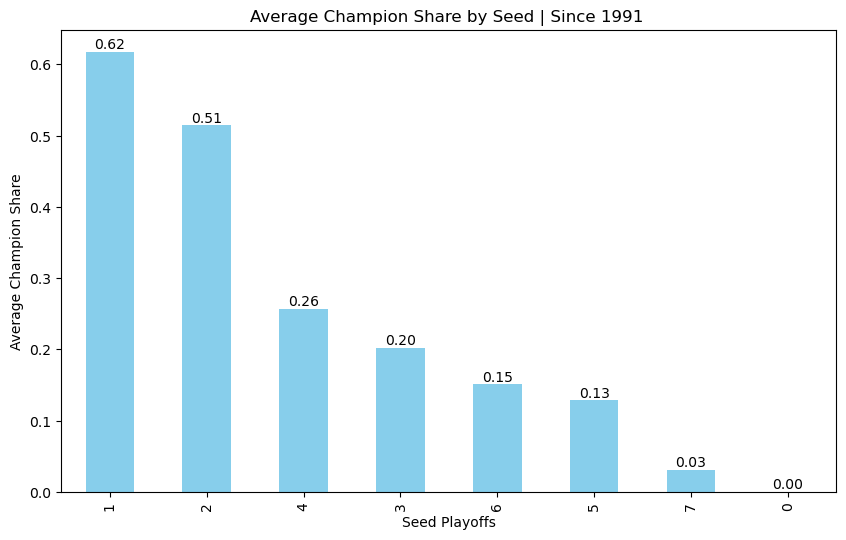

Max Champion Share by Seed | Since 1991
seed
1    1.00
2    1.00
3    1.00
4    1.00
5    1.00
6    1.00
7    0.25
0    0.00
Name: champion_share, dtype: float64


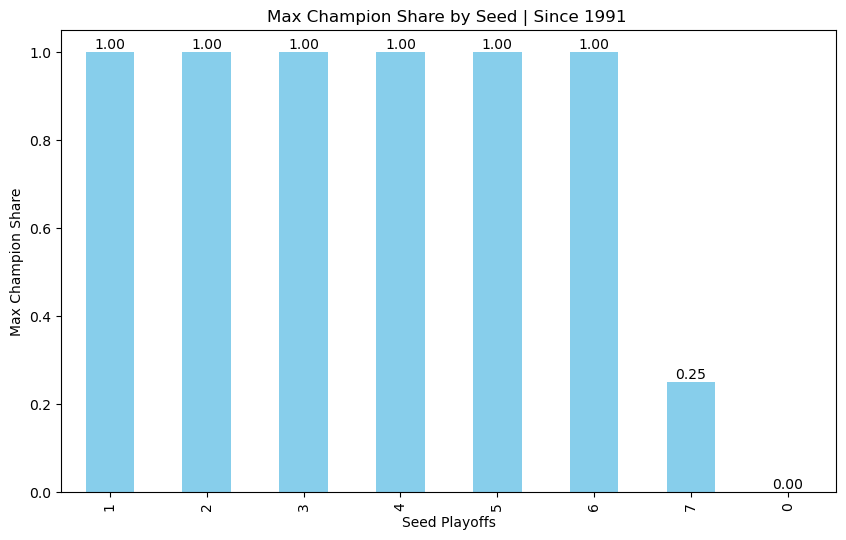

In [29]:
avg_champion_share = df.groupby('seed')['champion_share'].mean()
avg_champion_share_sorted = avg_champion_share.sort_values(ascending=False)

print("Average Champion Share by Seed | Since 1991")
print(avg_champion_share_sorted)

fig, ax = plt.subplots(figsize=(10, 6))

ax = avg_champion_share_sorted.plot(kind='bar', color='skyblue')
plt.title('Average Champion Share by Seed | Since 1991 ')
plt.xlabel('Seed Playoffs')
plt.ylabel('Average Champion Share')

for i, v in enumerate(avg_champion_share_sorted):
    ax.text(i, v - 0.0,f'{v:.2f}', ha='center', va='bottom')

plt.savefig("avg_cs_seed.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("avg_cs_seed.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("avg_cs_seed.png")    
    
plt.show()    

#=========================================================================================================================

max_champion_share = df.groupby('seed')['champion_share'].max()
max_champion_share_sorted = max_champion_share.sort_values(ascending=False)

print("Max Champion Share by Seed | Since 1991")
print(max_champion_share_sorted)

fig, ax = plt.subplots(figsize=(10, 6))

ax = max_champion_share_sorted.plot(kind='bar', color='skyblue')
plt.title('Max Champion Share by Seed | Since 1991 ')
plt.xlabel('Seed Playoffs')
plt.ylabel('Max Champion Share')

for i, v in enumerate(max_champion_share_sorted):
    ax.text(i, v - 0.0,f'{v:.2f}', ha='center', va='bottom')
    
plt.savefig("max_cs_seed.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("max_cs_seed.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("max_cs_seed.png")   

plt.show()

In [26]:
print("============================= Conference Semi Advance % =====================================\n")

for seed in range(1, 8):
    total_seeds = df[df['seed'] == seed] 
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.2]  

 
    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.25: {percentage_qualified_seeds}%")

print("\n")
print("============================= Conference Championship Advance % =====================================\n")

for seed in range(1, 8):
    total_seeds = df[df['seed'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.5]  

    
    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.5: {percentage_qualified_seeds}%")
    
print("\n")
print("============================= Super Bowl Advance % =====================================\n")

for seed in range(1, 8):
    total_seeds = df[df['seed'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] >= 0.70]  

  
    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share >= 0.75: {percentage_qualified_seeds}%")    
    
print("\n")
print("============================= Champion Advance % =====================================\n")

for seed in range(1, 8):
    total_seeds = df[df['seed'] == seed]  
    qualified_seeds = total_seeds[total_seeds['champion share'] == 1]  

 
    count_qualified_seeds = len(qualified_seeds)
    total_seeds_count = len(total_seeds)

    percentage_qualified_seeds = (count_qualified_seeds / total_seeds_count) * 100

    print(f"Percentage of {seed} seeds with champion share == 1: {percentage_qualified_seeds}%")

============================= Conference Semi Advance % =====================================

Percentage of 1 seeds with champion share >= 0.25: 100.0%
Percentage of 2 seeds with champion share >= 0.25: 97.05882352941177%
Percentage of 3 seeds with champion share >= 0.25: 52.94117647058824%
Percentage of 4 seeds with champion share >= 0.25: 61.76470588235294%
Percentage of 5 seeds with champion share >= 0.25: 35.294117647058826%
Percentage of 6 seeds with champion share >= 0.25: 44.11764705882353%
Percentage of 7 seeds with champion share >= 0.25: 0.0%


============================= Conference Championship Advance % =====================================

Percentage of 1 seeds with champion share >= 0.5: 70.58823529411765%
Percentage of 2 seeds with champion share >= 0.5: 70.58823529411765%
Percentage of 3 seeds with champion share >= 0.5: 14.705882352941178%
Percentage of 4 seeds with champion share >= 0.5: 17.647058823529413%
Percentage of 5 seeds with champion share >= 0.5: 10.2941

### Analysis of Champion Seeding
- 14/23 NFL Champions are top 2 seeds
- on average the NFL champion must be a top 2 seed.
- The 3 seed is a disadvantage, lowest champion occuerence seed.
- The 4 seed is a sweet spot.

C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\allen\Anaconda_Files\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

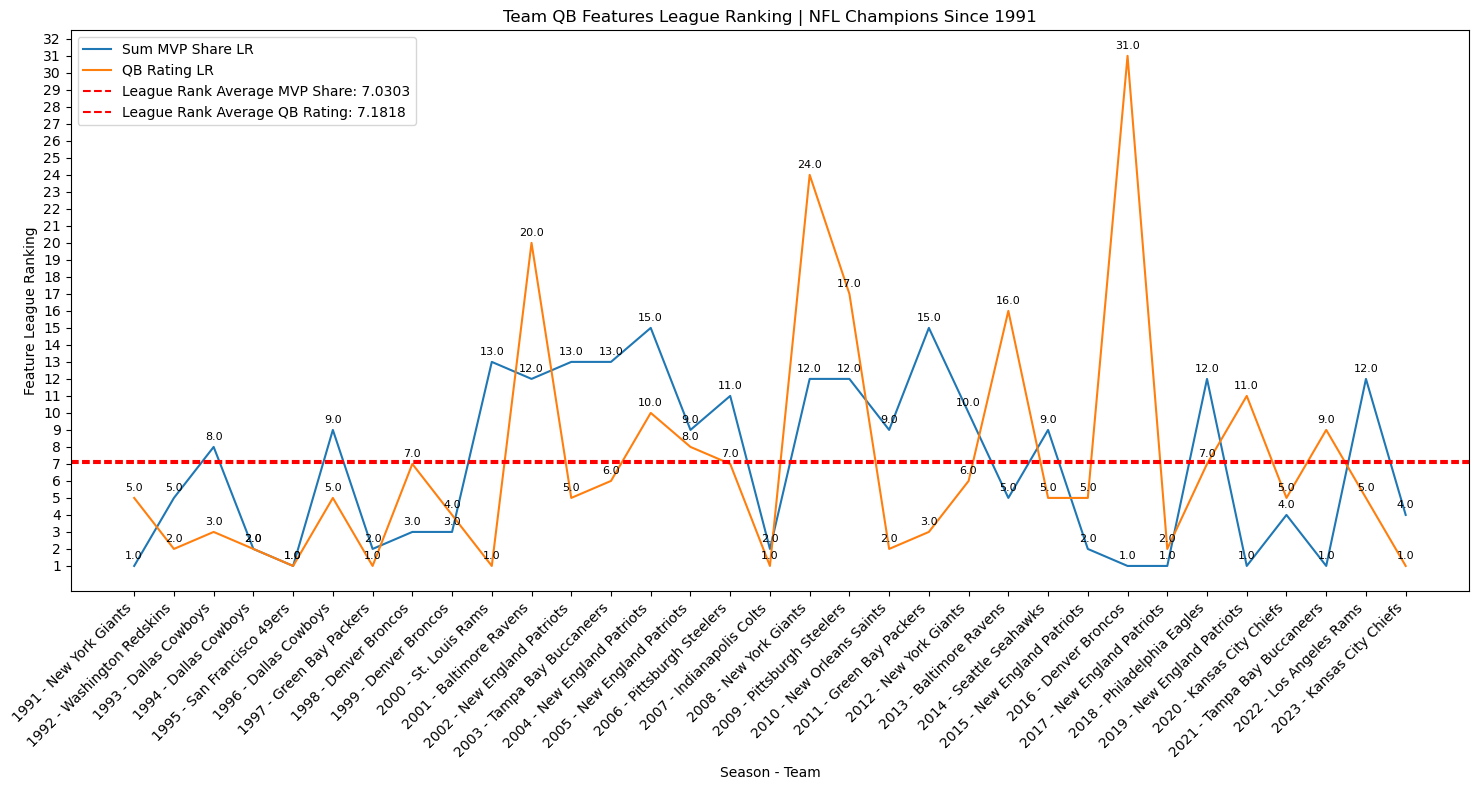

In [27]:
champion = df.loc[df['champion share'] == 1.00].copy()

champion.sort_values(by='Season', inplace=True)

plt.figure(figsize=(15, 8))

champion.loc[:, 'Season_Team'] = champion['Season'].astype(str) + " - " + champion['Team']

sns.lineplot(x=champion['Season_Team'], y=champion['sum mvp share'], label="Sum MVP Share LR", errorbar=None)
sns.lineplot(x=champion['Season_Team'], y=champion['passing_offense_Rate'], label="QB Rating LR", errorbar=None)

plt.xticks(rotation=45, ha="right")
plt.yticks(range(1, 33))

average_mvp_ranking = champion['sum mvp share'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average MVP Share: {average_mvp_ranking:.4f}')

average_mvp_ranking = champion['passing_offense_Rate'].mean()
plt.axhline(y=average_mvp_ranking, color='r', linestyle='--', label=f'League Rank Average QB Rating: {average_mvp_ranking:.4f}')

for season_team, rank in zip(champion['Season_Team'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
    
for season_team, rank in zip(champion['Season_Team'], champion['passing_offense_Rate']):
    plt.annotate(f'{rank}', (season_team, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Team QB Features League Ranking | NFL Champions Since 1991")
plt.xlabel("Season - Team")
plt.ylabel("Feature League Ranking")
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_qb.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_qb.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_qb.png")

plt.show()

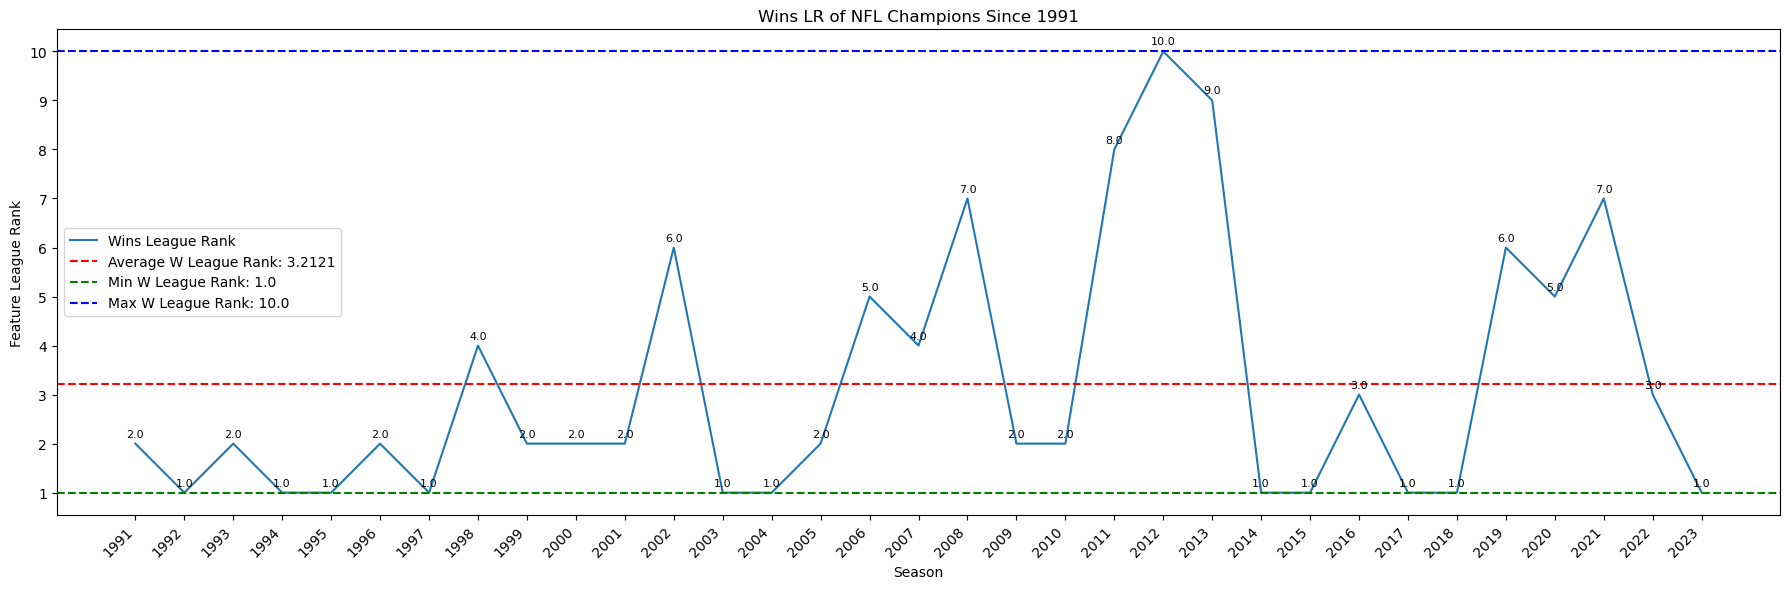

In [12]:
champion = df.loc[df['champion share'] == 1.00]

plt.figure(figsize=(18, 6))

sns.lineplot(x=champion['Season'], y=champion['W'], label="Wins League Rank", err_style="band")

plt.xticks(champion['Season'].unique(), rotation=45, ha="right")

plt.yticks(range(1, 11))

average_champion_wins_ranking = champion['W'].mean()
min_champion_wins_ranking = champion['W'].min()
max_champion_wins_ranking = champion['W'].max()

plt.axhline(y=average_champion_wins_ranking, color='r', linestyle='--', label=f'Average W League Rank: {average_champion_wins_ranking:.4f}')
plt.axhline(y=min_champion_wins_ranking, color='g', linestyle='--', label=f'Min W League Rank: {min_champion_wins_ranking}')
plt.axhline(y=max_champion_wins_ranking, color='b', linestyle='--', label=f'Max W League Rank: {max_champion_wins_ranking}')

for season, rank in zip(champion['Season'], champion['W']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Wins LR of NFL Champions Since 1991")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()
plt.tight_layout()

plt.savefig("line_chart_wins.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("line_chart_wins.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("line_chart_wins.png")

plt.show()

In [13]:
champions_df = df[df['champion share'] == 1.00]

unique_ranks = champions_df['W'].unique()
percentage_results = {}

for rank in unique_ranks:
    champions_with_rank = champions_df[champions_df['W'] == rank]
    total_champions = champions_df.shape[0]
    percentage = (champions_with_rank.shape[0] / total_champions) * 100
    percentage_results[f'Rank {rank}'] = percentage

sorted_results = sorted(percentage_results.items(), key=lambda x: x[1], reverse=True)

for rank, percentage in sorted_results:
    print(f"The percentage of champions Wins {rank}: {percentage:.2f}%")

The percentage of champions Wins Rank 1.0: 33.33%
The percentage of champions Wins Rank 2.0: 27.27%
The percentage of champions Wins Rank 3.0: 6.06%
The percentage of champions Wins Rank 7.0: 6.06%
The percentage of champions Wins Rank 5.0: 6.06%
The percentage of champions Wins Rank 6.0: 6.06%
The percentage of champions Wins Rank 4.0: 6.06%
The percentage of champions Wins Rank 9.0: 3.03%
The percentage of champions Wins Rank 10.0: 3.03%
The percentage of champions Wins Rank 8.0: 3.03%


### Analysis of Champion Wins LR
- 16/23 NFL Champions are top 5 teams in the league in Wins

In [44]:
#Champions | Summary Stats 
champion = df.loc[df['champion share'] == 1.00]
champion_wins_rank_summary = champion['W'].describe()

print("Summary Statistics for Champions' League Rank of Wins:")
print(champion_wins_rank_summary)

champion = df.loc[df['champion share'] == 1.00]
champion_srs_rank_summary = champion['SRS'].describe()

print("Summary Statistics for Champions' League Rank of SRS:")
print(champion_srs_rank_summary)

Summary Statistics for Champions' League Rank of Wins:
count    24.000000
mean      3.750000
std       2.862805
min       1.000000
25%       1.000000
50%       2.500000
75%       6.000000
max      10.000000
Name: W, dtype: float64
Summary Statistics for Champions' League Rank of SRS:
count    24.000000
mean      4.458333
std       3.647264
min       1.000000
25%       1.000000
50%       3.500000
75%       6.250000
max      12.000000
Name: SRS, dtype: float64


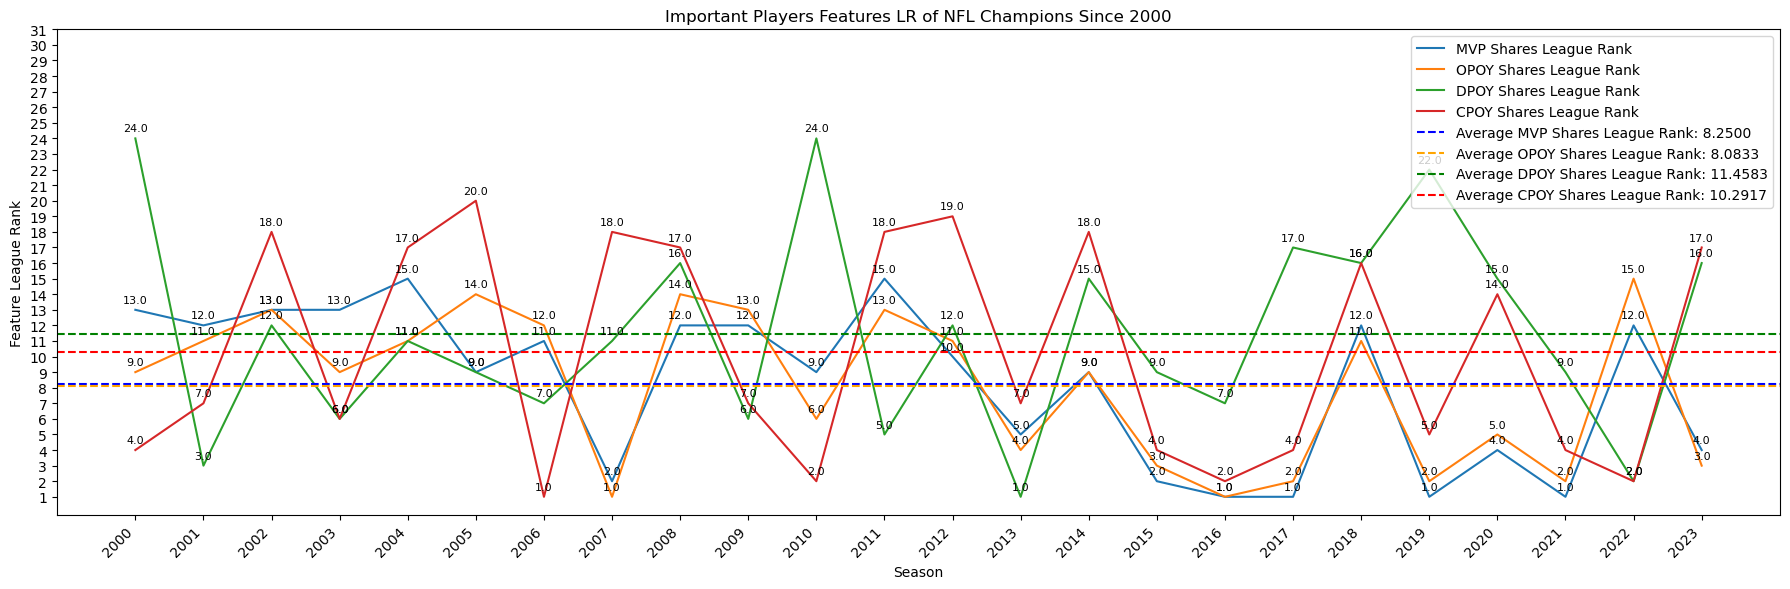

In [45]:
champion = df.loc[df['champion share'] == 1.00]
plt.figure(figsize=(18, 6))

sns.lineplot(x=champion['Season'], y=champion['sum mvp share'], label="MVP Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum opoy share'], label="OPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum dpoy share'], label="DPOY Shares League Rank", err_style="band")
sns.lineplot(x=champion['Season'], y=champion['sum cpoy share'], label="CPOY Shares League Rank", err_style="band")

plt.xticks(champion['Season'].unique(), rotation=45, ha="right")
plt.yticks(range(1, 32))

average_champion_ms_ranking = champion['sum mvp share'].mean()
average_champion_os_ranking = champion['sum opoy share'].mean()
average_champion_ds_ranking = champion['sum dpoy share'].mean()
average_champion_cs_ranking = champion['sum cpoy share'].mean()

plt.axhline(y=average_champion_ms_ranking, color='blue', linestyle='--', label=f'Average MVP Shares League Rank: {average_champion_ms_ranking:.4f}')
plt.axhline(y=average_champion_os_ranking, color='orange', linestyle='--', label=f'Average OPOY Shares League Rank: {average_champion_os_ranking:.4f}')
plt.axhline(y=average_champion_ds_ranking, color='green', linestyle='--', label=f'Average DPOY Shares League Rank: {average_champion_ds_ranking:.4f}')
plt.axhline(y=average_champion_cs_ranking, color='red', linestyle='--', label=f'Average CPOY Shares League Rank: {average_champion_cs_ranking:.4f}')

for season, rank in zip(champion['Season'], champion['sum mvp share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum opoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum dpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
for season, rank in zip(champion['Season'], champion['sum cpoy share']):
    plt.annotate(f'{rank}', (season, rank), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')

plt.title("Important Players Features LR of NFL Champions Since 2000")
plt.xlabel("Season")
plt.ylabel("Feature League Rank")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

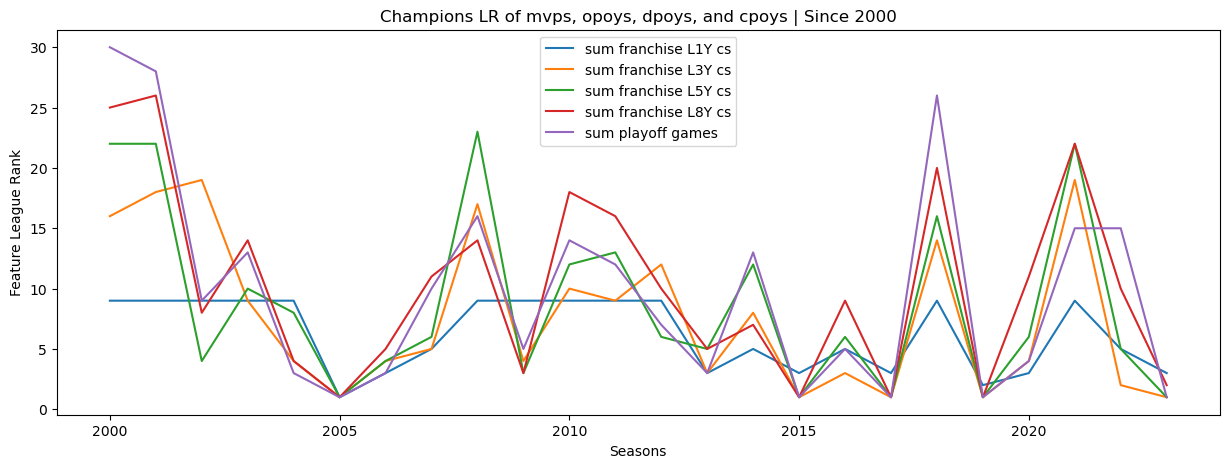

In [47]:
champion_sea = df.loc[df['champion share']==1]

plt.figure(figsize=(15,5))
plt.title("Champions LR of mvps, opoys, dpoys, and cpoys | Since 2000")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L1Y cs'],label="sum franchise L1Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L3Y cs'],label="sum franchise L3Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L5Y cs'],label="sum franchise L5Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum franchise L8Y cs'],label="sum franchise L8Y cs")
sns.lineplot(x=champion_sea.Season, y=champion_sea['sum playoff games'],label="sum playoff games")
plt.xlabel('Seasons')
plt.ylabel('Feature League Rank')
plt.show()

Pearson Correlation Coefficient: 0.7217


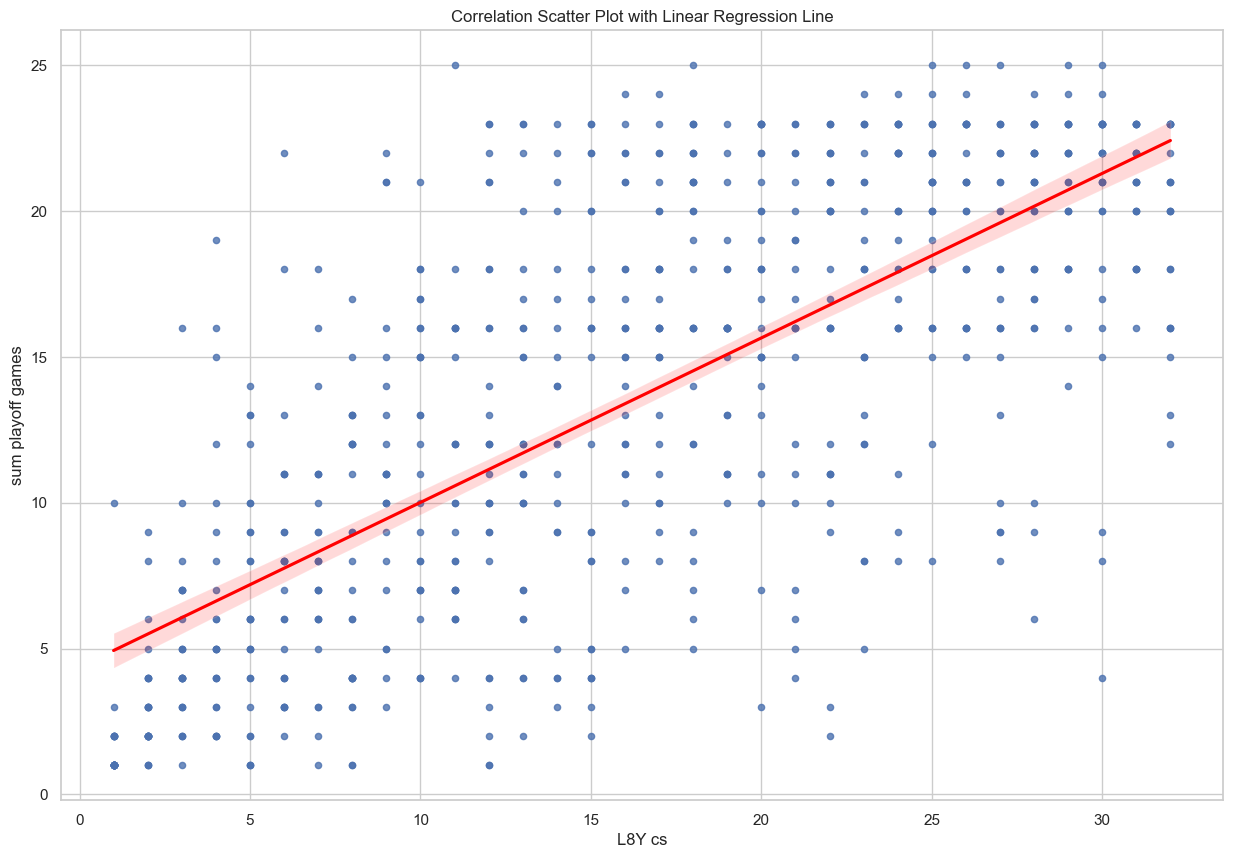

In [49]:
from scipy.stats import pearsonr
sns.set(style="whitegrid") 
sns.regplot(x=data['sum playoff games'], y=data['sum franchise L5Y cs'], scatter_kws={"s": 20}, line_kws={"color": "red"})

plt.xlabel("L8Y cs")
plt.ylabel("sum playoff games")
plt.title("Correlation Scatter Plot with Linear Regression Line")

correlation_coefficient, _ = pearsonr(data['sum playoff games'], data['sum franchise L5Y cs'])
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")

plt.show()

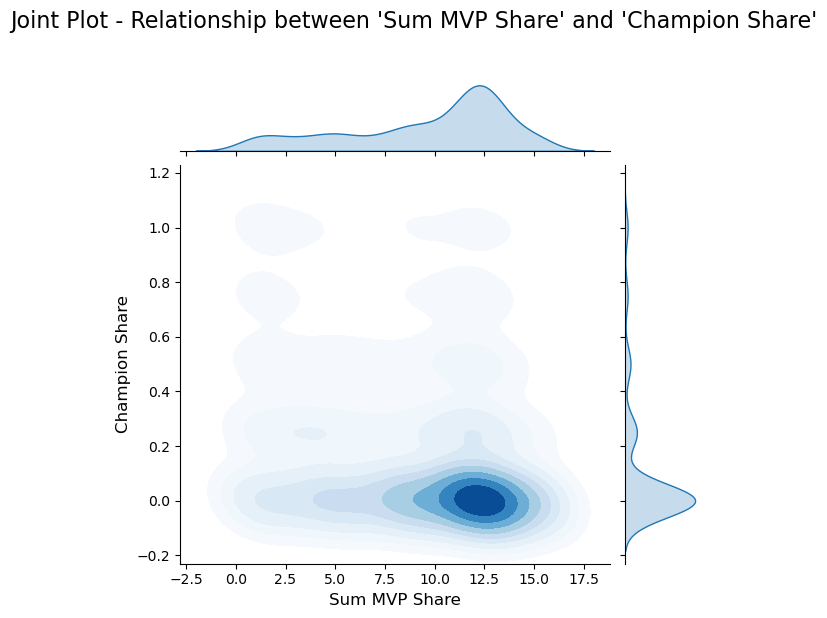

In [15]:
joint_plot = sns.jointplot(x=df['sum mvp share'], y=df['champion share'], kind='kde', fill=True, cmap='Blues')
joint_plot.set_axis_labels("Sum MVP Share", "Champion Share", fontsize=12)
joint_plot.fig.suptitle("Joint Plot - Relationship between 'Sum MVP Share' and 'Champion Share'", y=1.02, fontsize=16)
joint_plot.fig.subplots_adjust(top=0.9)
plt.show()

In [6]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

Column Averages:
SRS                               3.757576
2 seed                            0.242424
1 seed                            0.454545
4 seed                            0.151515
passing_offense_EXP               5.333333
team_defense_Rushing_Yds         23.060606
team_offense_Sc%                  6.515152
pso                               6.242424
OSRS                              5.636364
passing_offense_AY/A              6.818182
passing_offense_4QC              11.212121
6 seed                            0.060606
3 seed                            0.030303
team_offense_Tot Yds & TO_Yds     9.151515
team_offense_Tot Yds & TO_Ply    12.272727
sum all pro                       9.303030
team_offense_Rushing_Yds         12.242424
team_defense_Passing_TD          22.151515
DSRS                              7.333333
team_offense_Rushing_TD          10.272727
team_offense_Passing_Yds         10.212121
sum playoff games                 8.363636
team_defense_Sc%                 18.8

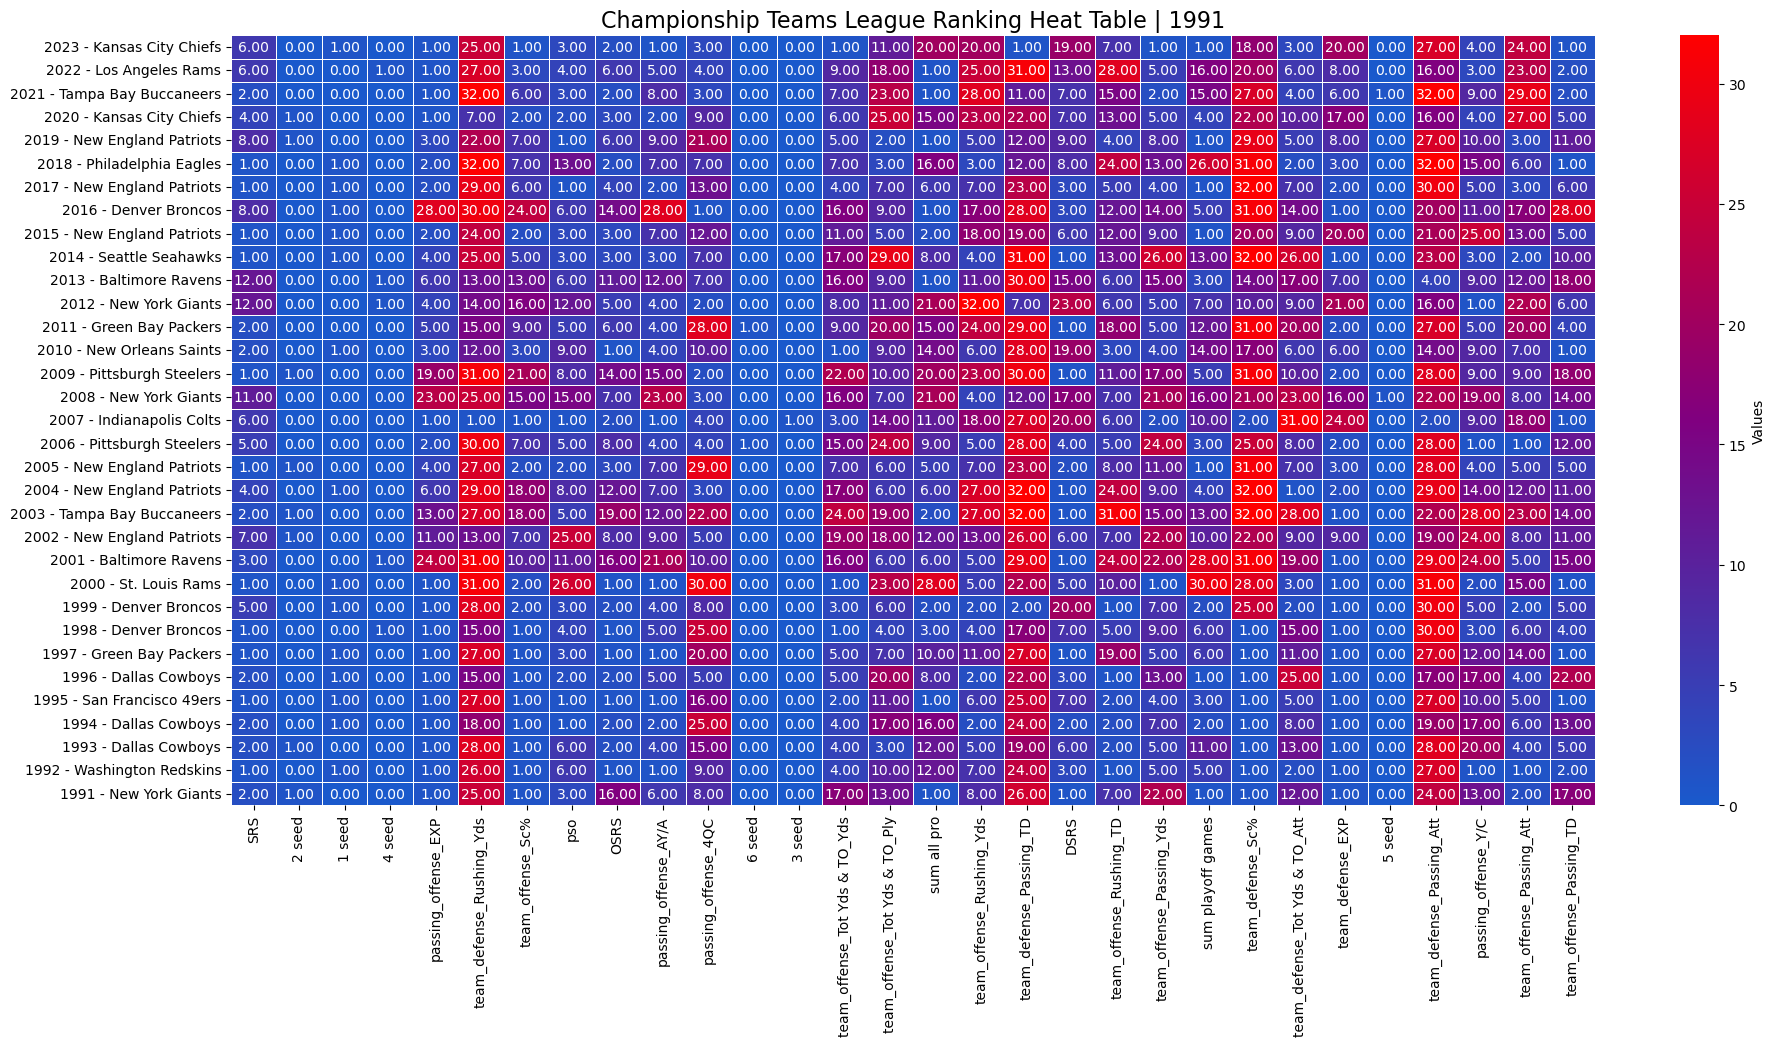

In [32]:
from matplotlib.colors import ListedColormap
df = pd.read_csv("NFL Champion LR Data.csv")
#df = pd.read_csv("NFL Champion RawData.csv")

champions_only = df[df['champion share'] == 1]

custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'  
middle_color = 'purple'
small_color = (0.1, 0.35, .8)

large_threshold = 1.5  
middle_threshold = 0.5 

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(22, 10))
heatmap_data = champions_only[['SRS', '2 seed', '1 seed', '4 seed', 'passing_offense_EXP', 'team_defense_Rushing_Yds', 'team_offense_Sc%', 'pso', 'OSRS', 'passing_offense_AY/A', 'passing_offense_4QC', '6 seed', '3 seed', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'sum all pro', 'team_offense_Rushing_Yds', 'team_defense_Passing_TD', 'DSRS', 'team_offense_Rushing_TD', 'team_offense_Passing_Yds', 'sum playoff games', 'team_defense_Sc%', 'team_defense_Tot Yds & TO_Att', 'team_defense_EXP', '5 seed', 'team_defense_Passing_Att', 'passing_offense_Y/C', 'team_offense_Passing_Att', 'team_offense_Passing_TD']]
heatmap = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=.5, cbar_kws={'label': 'Values'}, vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_averages = heatmap_data.mean()
print("Column Averages:")
print(column_averages)

plt.title('Championship Teams League Ranking Heat Table | 1991', fontsize=16)
plt.savefig("ht_allChamps_fea_table.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_allChamps_fea_table.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_allChamps_fea_table.png")

plt.show()

In [54]:
print(list(df.columns))

['Season', 'Team ID', ' Team ID/Season', 'Team', 'Team/Season', 'over500 rec', 'over500 mov', '7 point rec', 'sum mvp share', 'sum dpoy share', 'sum opoy share', 'sum all pro', 'sum cpoy share', 'sum playoff games', 'sum champion', 'sum team L1Y cs', 'sum team L3Y cs', 'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 'sum franchise L5Y cs', 'sum franchise L8Y cs', 'W', 'L', 'T', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make playoffs', 'rk playoffs', '1 seed', '2 seed', '3 seed', '4 seed', '5 seed', '6 seed', 'champion share', 'pso', 'team_offense_G', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Pass

## Analyzing Champions outside of the top 6 in SRS

Column Averages:
over500 rec                      7.833333
over500 mov                     10.833333
sum mvp share                    7.000000
sum dpoy share                  11.666667
sum opoy share                   7.500000
sum all pro                      9.500000
sum cpoy share                  11.333333
sum playoff games                7.000000
sum champion                    17.166667
sum team L1Y cs                 10.666667
sum team L3Y cs                 11.666667
sum team L5Y cs                 10.000000
sum team L8Y cs                  9.833333
sum franchise L1Y cs             6.166667
sum franchise L3Y cs             9.166667
sum franchise L5Y cs             7.666667
sum franchise L8Y cs             7.833333
W-L%                             6.833333
PF                              10.333333
PA                              20.833333
PD                              10.833333
MoV                             10.833333
SoS                             16.666667
SRS              

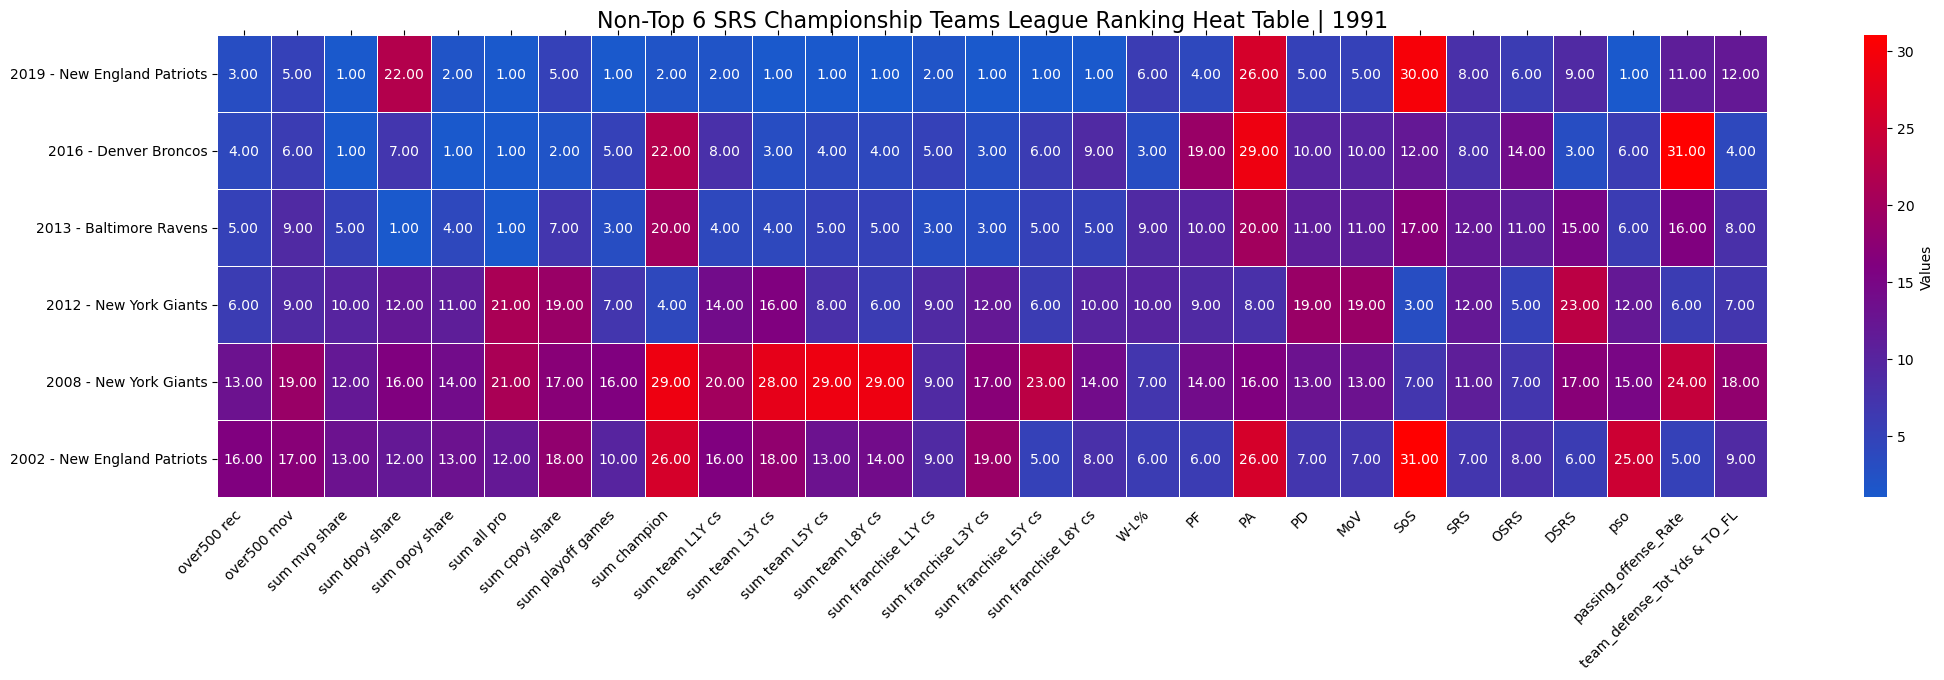

In [28]:
df = pd.read_csv("NFL Champion LR Data.csv")
#df = pd.read_csv("NFL Champion RawData.csv")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps

teams_of_interest = ['New England Patriots 2018', 'Denver Broncos 2015', 'Baltimore Ravens 2012', 'New York Giants 2011', 'New York Giants 2007','New England Patriots 2001']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['over500 rec', 'over500 mov', 
                   'sum mvp share', 'sum dpoy share', 'sum opoy share',
                   'sum all pro', 'sum cpoy share', 'sum playoff games',
                   'sum champion', 'sum team L1Y cs', 'sum team L3Y cs',
                   'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 
                   'sum franchise L5Y cs', 'sum franchise L8Y cs','W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','pso','passing_offense_Rate','team_defense_Tot Yds & TO_FL']


custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'
middle_color = 'purple'
small_color = (0.1, 0.35, 0.8)

large_threshold = 1.5
middle_threshold = 0.5

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(25, 6))
heatmap = sns.heatmap(
    champions_only[numeric_columns],
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=.5,
    cbar_kws={'label': 'Values'},
    vmin=champions_only[numeric_columns].min().min(),
    vmax=champions_only[numeric_columns].max().max()
)

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Non-Top 6 SRS Championship Teams League Ranking Heat Table | 1991', fontsize=16)
plt.savefig("ht_champs_nt6_srs.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_champs_nt6_srs.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_champs_nt6_srs.png")
plt.show()


Column Averages:
over500 rec                        0.517659
over500 mov                       -0.614583
sum mvp share                      1.343167
sum dpoy share                     0.533000
sum opoy share                     0.749833
sum all pro                       18.166667
sum cpoy share                     0.216333
sum playoff games                196.666667
sum champion                       7.500000
sum team L1Y cs                    6.416667
sum team L3Y cs                   16.625000
sum team L5Y cs                   24.458333
sum team L8Y cs                   28.000000
sum franchise L1Y cs               0.250000
sum franchise L3Y cs               0.791667
sum franchise L5Y cs               1.500000
sum franchise L8Y cs               1.916667
W-L%                               0.656250
PF                               387.833333
PA                               331.333333
PD                                56.500000
MoV                                3.533333
SoS            

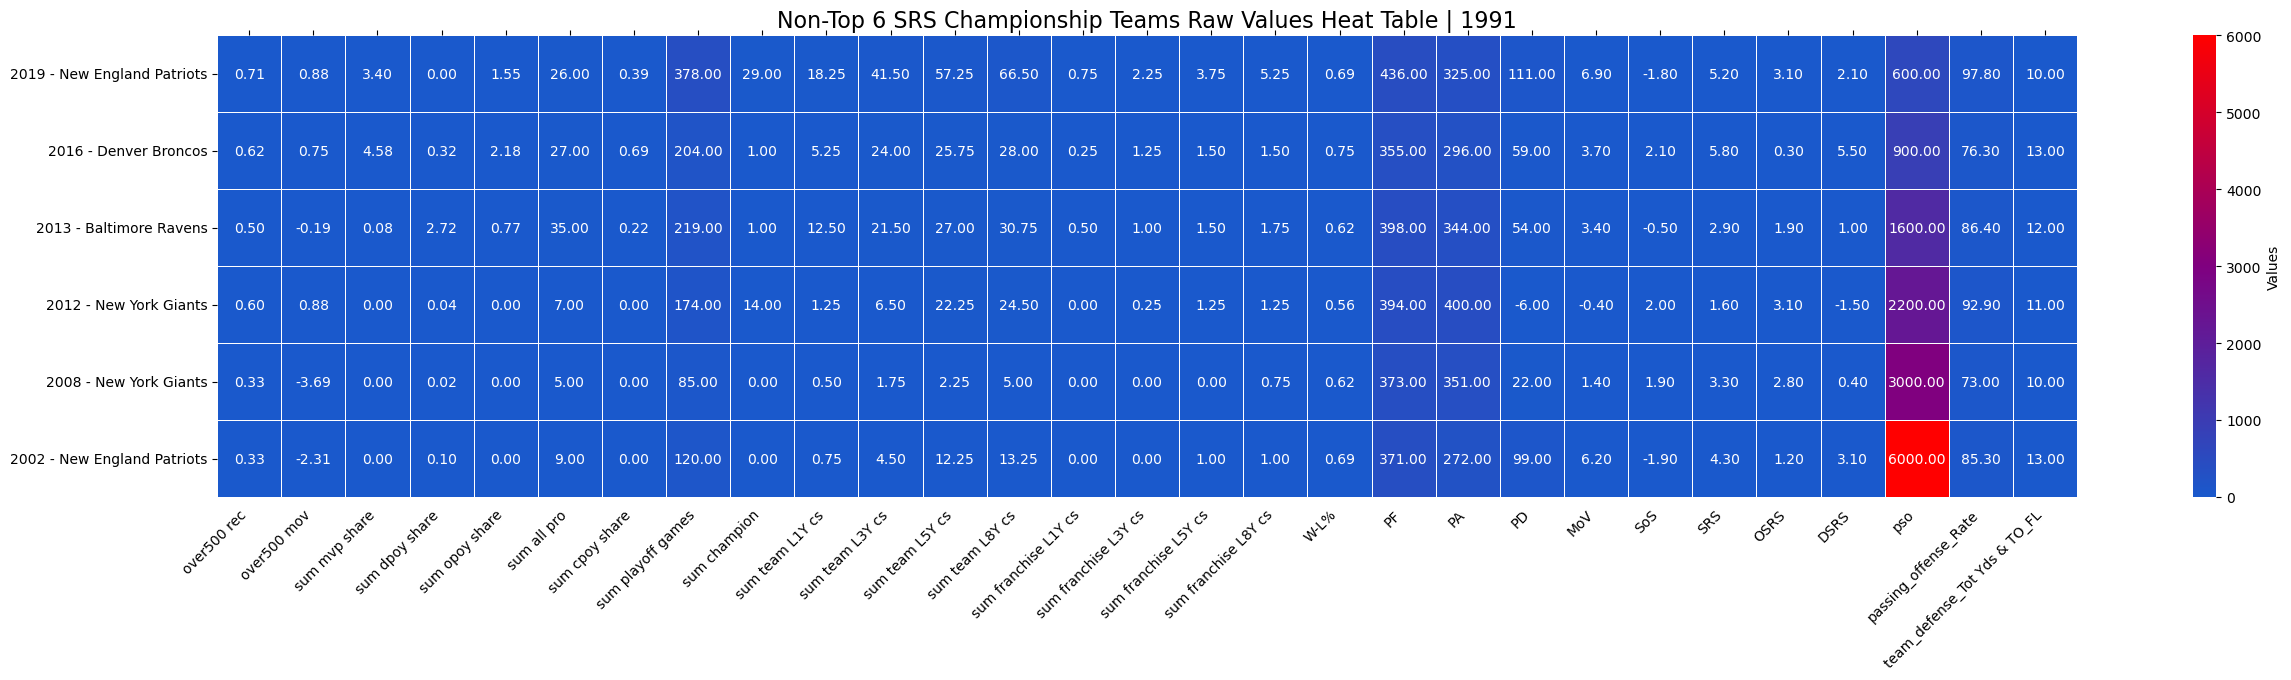

In [35]:
#df = pd.read_csv("NFL Champion LR Data.csv")
df = pd.read_excel("NFL Champion RawData.xlsx")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps

teams_of_interest = ['New England Patriots 2018', 'Denver Broncos 2015', 'Baltimore Ravens 2012', 'New York Giants 2011', 'New York Giants 2007','New England Patriots 2001']
champions_only = df[df['Team/Season'].isin(teams_of_interest)].copy()  

numeric_columns = ['over500 rec', 'over500 mov',
                   'sum mvp share', 'sum dpoy share', 'sum opoy share',
                   'sum all pro', 'sum cpoy share', 'sum playoff games',
                   'sum champion', 'sum team L1Y cs', 'sum team L3Y cs',
                   'sum team L5Y cs', 'sum team L8Y cs', 'sum franchise L1Y cs', 'sum franchise L3Y cs', 
                   'sum franchise L5Y cs', 'sum franchise L8Y cs','W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS','pso','passing_offense_Rate','team_defense_Tot Yds & TO_FL']


custom_palette = sns.color_palette("pastel", as_cmap=True)

large_color = 'red'
middle_color = 'purple'
small_color = (0.1, 0.35, 0.8)

large_threshold = 1.5
middle_threshold = 0.5

colors = sns.color_palette([small_color, middle_color, large_color], as_cmap=True)
custom_cmap = sns.blend_palette(colors, as_cmap=True)

plt.figure(figsize=(30, 6))
heatmap = sns.heatmap(
    champions_only[numeric_columns],
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=.5,
    cbar_kws={'label': 'Values'},
    vmin=champions_only[numeric_columns].min().min(),
    vmax=champions_only[numeric_columns].max().max()
)

championship_teams_labels = ['{} - {}'.format(season, team) for season, team in zip(champions_only['Season'], champions_only['Team'])]
plt.yticks(ticks=[i + 0.5 for i in range(len(championship_teams_labels))], labels=championship_teams_labels, rotation=0)

column_headers = numeric_columns
plt.xticks(ticks=[i + 0.5 for i in range(len(column_headers))], labels=column_headers, rotation=45, ha="right")

plt.tick_params(axis='x', which='both', bottom=False, top=True)

column_averages = champions_only[numeric_columns].mean()
print("Column Averages:")
print(column_averages)

plt.title('Non-Top 6 SRS Championship Teams Raw Values Heat Table | 1991', fontsize=16)
plt.savefig("ht_champs_nt6_srs.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ht_champs_nt6_srs.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ht_champs_nt6_srs.png")
plt.show()